# CNN Model Template

This notebook is a template for building a CNN model.

## Imports and inital setup

In [10]:
# Imports
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

import sys

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 856
NUM_EPOCHS = 6

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

TARGET_LABEL="dx_binary"

IMAGE_SIZE = (224, 224)

### Loading (augmented) metadata as test, train, validation from files

In [11]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
1974,HAM_0003853,aug_r5JEOVISIC_0030644.jpg,bcc,histo,85.0,male,face,rosendahl,skin_cancer,./../data/jpgs/aug_r5JEOVISIC_0030644.jpg
74,HAM_0006909,ISIC_0031777.jpg,nv,follow_up,45.0,female,lower extremity,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0031777.jpg
5046,HAM_0005276,aug_LnLIo7ISIC_0027008.jpg,df,histo,75.0,male,back,vidir_modern,not_skin_cancer,./../data/jpgs/aug_LnLIo7ISIC_0027008.jpg
3640,HAM_0006938,ISIC_0033716.jpg,bkl,histo,45.0,male,face,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0033716.jpg
3186,HAM_0002902,ISIC_0026443.jpg,bkl,histo,80.0,female,lower extremity,rosendahl,not_skin_cancer,./../data/jpgs/ISIC_0026443.jpg
5144,HAM_0003290,aug_UngMyEISIC_0031735.jpg,df,histo,80.0,male,upper extremity,rosendahl,not_skin_cancer,./../data/jpgs/aug_UngMyEISIC_0031735.jpg
2809,HAM_0006875,aug_amRdwmISIC_0030586.jpg,akiec,histo,80.0,male,face,vidir_modern,skin_cancer,./../data/jpgs/aug_amRdwmISIC_0030586.jpg
282,HAM_0006881,ISIC_0026922.jpg,nv,histo,60.0,female,face,rosendahl,not_skin_cancer,./../data/jpgs/ISIC_0026922.jpg
633,HAM_0000676,ISIC_0033894.jpg,nv,histo,40.0,male,back,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0033894.jpg
1167,HAM_0002525,ISIC_0025188.jpg,mel,histo,55.0,male,face,rosendahl,skin_cancer,./../data/jpgs/ISIC_0025188.jpg


## Setting up the image data generator for training and validation

In [12]:
def custom_preprocessing(np_image, image_size):
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image
    np_image = preprocess_input(np_image) # Apply the preprocess_input function of MobileNetV3Large
    return np_image

In [13]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0, # Rescale pixel values to [0, 1], important for CNNs to perform better
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
)

datagen_validation = ImageDataGenerator(
    rescale=1.0 / 255.0,
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=32
)

train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=32
)

Found 1735 validated image filenames belonging to 2 classes.
Found 5256 validated image filenames belonging to 2 classes.


# Using MobileNet V3 large

In [14]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [15]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.00001)

In [17]:
PRETRAINED = True

if PRETRAINED:
    # Initialize the MobileNetV3Large model
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Freeze the base model's layers to use it for feature extraction
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top 
    x = layers.Conv2D(128, (3, 3), activation='relu')(base_model.output)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # 50% dropout /new
    x = layers.Dense(train_df[TARGET_LABEL].nunique(), activation='sigmoid')(x) 

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x, name="MobilneNetV3Large_pretrained-weights_binary_fixed-layers_custom-conv2D")

    # Setting an optimizer
    opt = SGD(learning_rate=0.01, 
                momentum=0.9
                # nesterov=True,
                # decay=0.01
              )

    # Compile the model
    model.compile(optimizer=opt,
                loss='binary_crossentropy',
                #loss = focal_loss(),
                metrics=[
                        #Recall(), 
                        #Precision(), 
                        'accuracy',
                        f1_score
                        ])

    model.summary()

else:
    # Initialize the MobileNetV3Large model
    base_model = MobileNetV3Large(weights=None, include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Freeze the base model's layers to use it for feature extraction
    for layer in base_model.layers:
        layer.trainable = True

    # Add custom layers on top 
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(train_df[TARGET_LABEL].nunique(), activation='sigmoid')(x) 

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x, name="MobilneNetV3Large_rand-weights")


    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy'])

    model.summary()


Model: "MobilneNetV3Large_pretrained-weights_binary_fixed-layers_custom-conv2D"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_1[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                   

## Model Training

In [18]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=None,                # Set the batch size, default is 32, can be increased to speed up training
    callbacks=[reduce_lr],                 # List of callbacks to apply during training 
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

Epoch 1/6
165/165 [==============================] - 90s 520ms/step - loss: 0.6972 - accuracy: 0.5634 - f1_score: 0.5431 - val_loss: 0.6844 - val_accuracy: 0.5712 - val_f1_score: 0.5752 - lr: 0.0100
Epoch 2/6
165/165 [==============================] - 94s 571ms/step - loss: 0.6832 - accuracy: 0.5713 - f1_score: 0.5705 - val_loss: 0.6830 - val_accuracy: 0.5712 - val_f1_score: 0.5732 - lr: 0.0100
Epoch 3/6
165/165 [==============================] - 94s 566ms/step - loss: 0.6836 - accuracy: 0.5713 - f1_score: 0.5710 - val_loss: 0.6830 - val_accuracy: 0.5712 - val_f1_score: 0.5732 - lr: 0.0100
Epoch 4/6
165/165 [==============================] - ETA: 0s - loss: 0.6831 - accuracy: 0.5713 - f1_score: 0.5705

## Plotting accuracy and loss of train and validation set

In [ ]:
# mh.model_plot_accuracy(history)

## Evaluating the model on the test set

 > Evaluating model MobilneNetV3Large_pretrained-weights_binary_fixed-layers_custom-conv2D:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
63/63 [==============================] - 25s 381ms/step
 > Model predictions obtained.
 > ROC AUC: 0.5


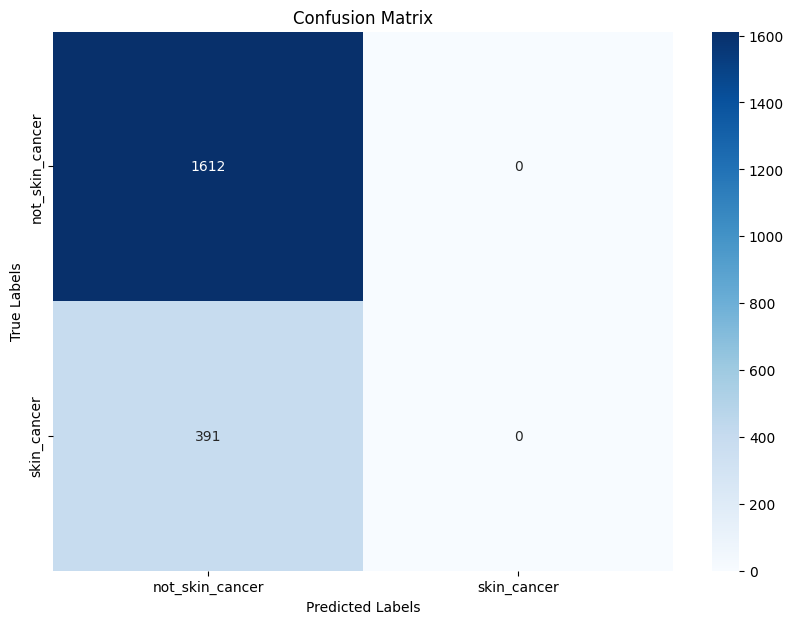



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1612
           1       0.00      0.00      0.00       391

    accuracy                           0.80      2003
   macro avg       0.40      0.50      0.45      2003
weighted avg       0.65      0.80      0.72      2003

 > Evaluating model on test set...


/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

ValueError: in user code:

    File "/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1853, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1179, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/metrics/accuracy_metrics.py", line 459, in sparse_categorical_accuracy
        matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 960, in sparse_categorical_matches
        y_true = tf.squeeze(y_true, [-1])

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 2 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](IteratorGetNext:1)' with input shapes: [?,2].


In [ ]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [ ]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
